## p9 101

In [1]:
import polars as pl
from plotnine import aes, geom_point, ggplot, theme_538

df_demo = pl.DataFrame(
    {
        "x": [1, 2, 3, 4, 5],
        "y": [1, 8, 4, 6, 2],
        "group": ["A", "B", "B", "C", "A"],
    }
)
print(df_demo)

shape: (5, 3)
┌─────┬─────┬───────┐
│ x   ┆ y   ┆ group │
│ --- ┆ --- ┆ ---   │
│ i64 ┆ i64 ┆ str   │
╞═════╪═════╪═══════╡
│ 1   ┆ 1   ┆ A     │
│ 2   ┆ 8   ┆ B     │
│ 3   ┆ 4   ┆ B     │
│ 4   ┆ 6   ┆ C     │
│ 5   ┆ 2   ┆ A     │
└─────┴─────┴───────┘


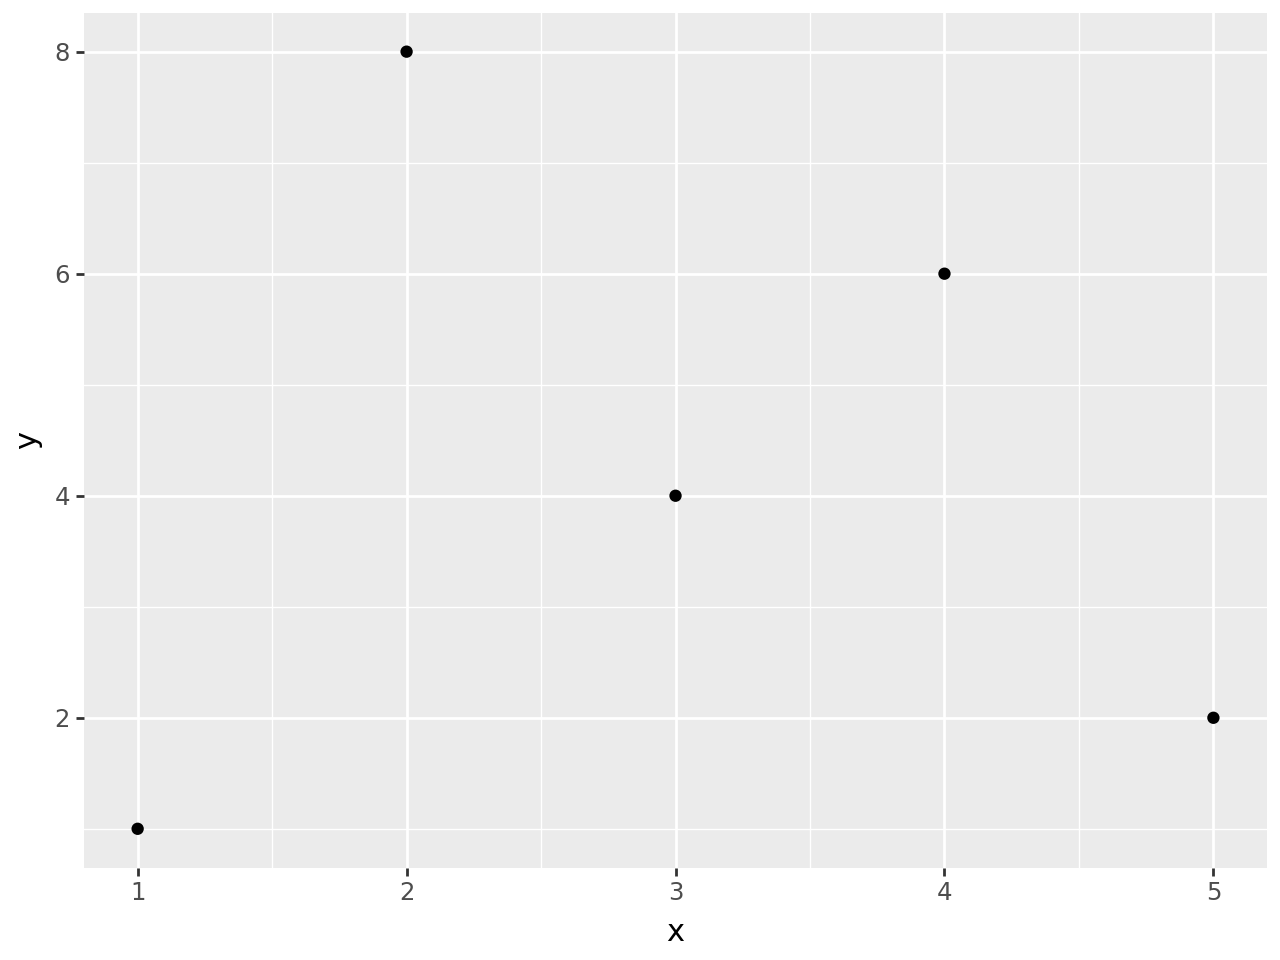

In [2]:
(ggplot(data=df_demo, mapping=aes(x="x", y="y")) + geom_point())

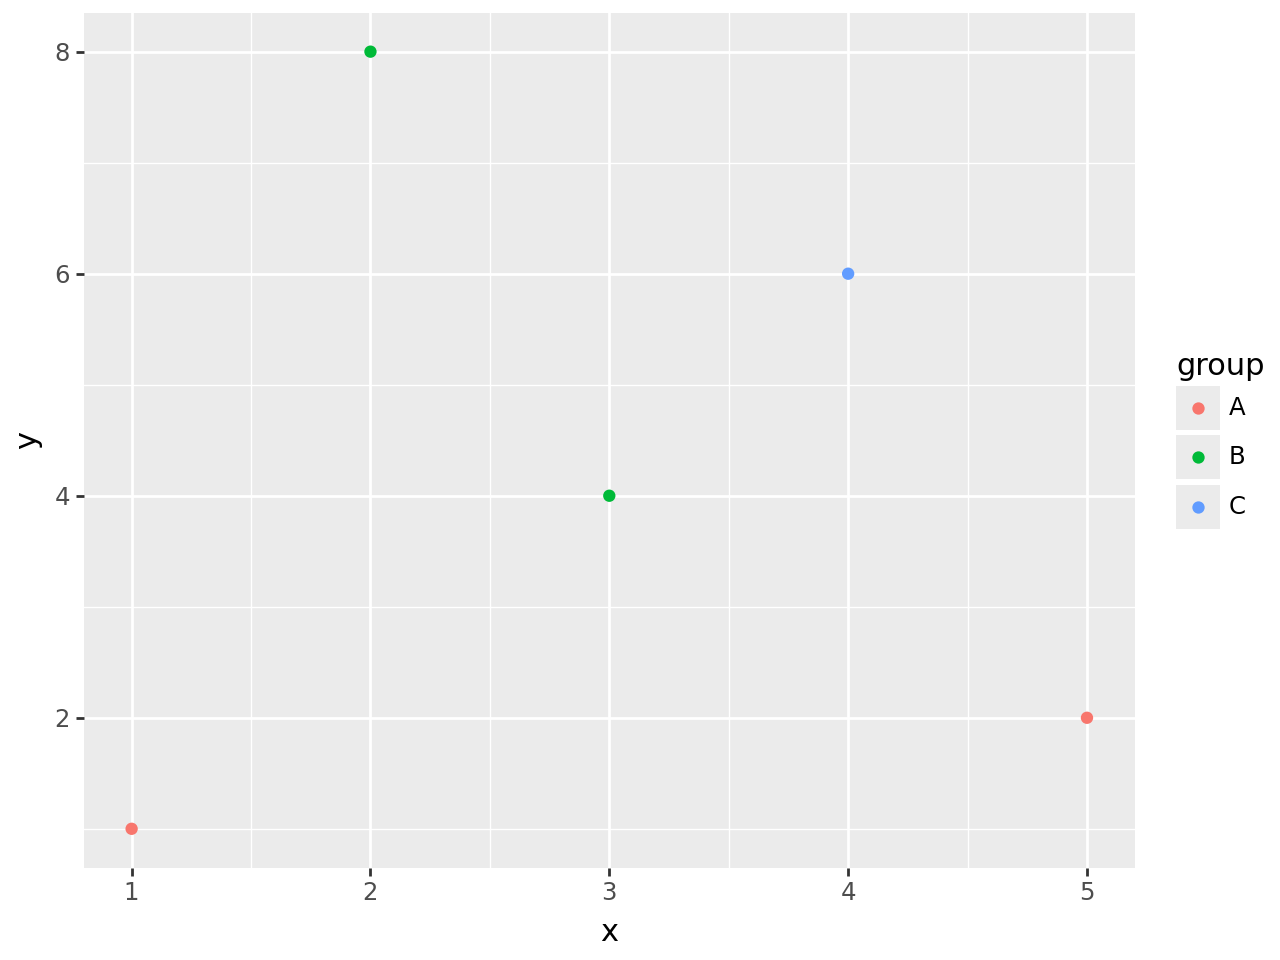

In [3]:
(
    ggplot(data=df_demo, mapping=aes(x="x", y="y", color="group"))
    + geom_point()
)

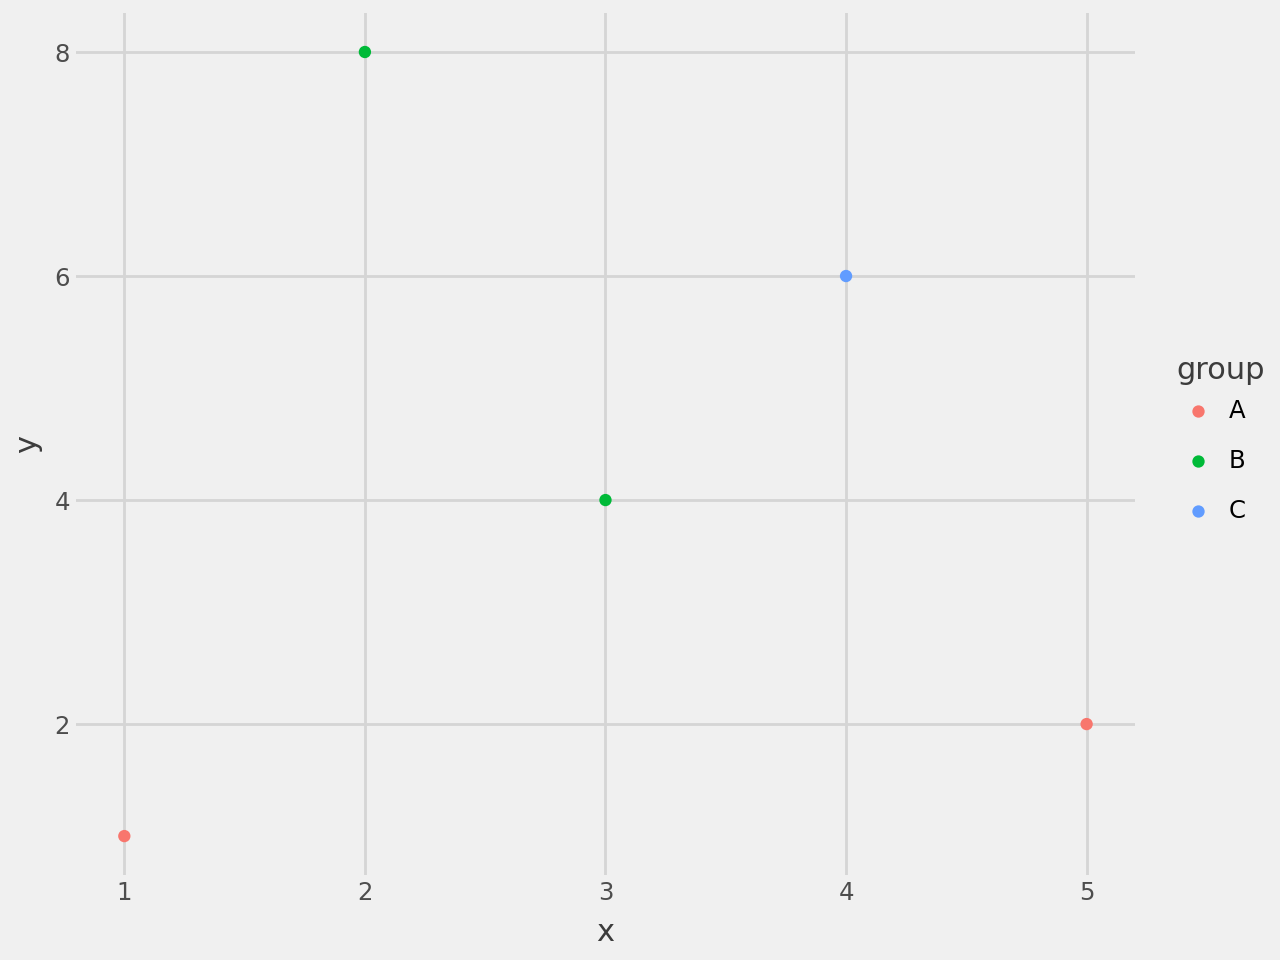

In [4]:
(
    ggplot(data=df_demo, mapping=aes(x="x", y="y", color="group"))
    + geom_point()
    + theme_538()
)

## Code

In [ ]:
import polars as pl
import polars.selectors as cs
from highlight_text import ax_text
from matplotlib.axes import Axes
from matplotlib.figure import Figure

from plotnine import (
    aes,
    element_blank,
    element_text,
    geom_line,
    geom_point,
    geom_segment,
    geom_text,
    ggplot,
    labs,
    scale_color_cmap,
    scale_x_continuous,
    scale_y_continuous,
    theme,
    theme_classic,
)

# https://github.com/mattharrison/datasets/raw/refs/heads/master/data/alta-noaa-1980-2019.csv
data_path = "alta-noaa-1980-2019.csv"
columns = ["DATE", "TOBS"]
idx_colname = "DAY_OF_SEASON"
temp_colname = "temp"

heading_fontsize = 9.5
heading_fontweight = "bold"
subheading_fontsize = 8
subheading_fontweight = "normal"
source_fontsize = 6.5
source_fontweight = "light"
axis_fontsize = 7
axis_fontweight = "normal"
sub_props = {
    "fontsize": subheading_fontsize,
    "fontweight": subheading_fontweight,
}

grey = "#aaaaaa"
red = "#e3120b"
blue = "#0000ff"


def get_season_expr(col: str = "DATE", alias: str = "SEASON") -> pl.expr:
    return (
        (
            pl.when(
                (pl.col(col).dt.month().is_between(5, 10, closed="both"))
            )
            .then(pl.lit("Summer "))
            .otherwise(pl.lit("Ski "))
        )
        .add(
            pl.when(pl.col(col).dt.month() < 11)
            .then(pl.col(col).dt.year().cast(pl.String))
            .otherwise(pl.col(col).dt.year().add(1).cast(pl.String))
        )
        .alias(alias)
    )


def add_day_of_season_expr(
    col: str = "DATE",
    group_col: str = "SEASON",
    alias: str = "DAY_OF_SEASON",
) -> pl.expr:
    return (
        (pl.col(col) - pl.col(col).min())
        .dt.total_days()
        .over(group_col)
        .alias(alias)
    )


def tweak_df(
    data_path: str, columns: list[str], idx_colname: str = "DAY_OF_SEASON"
) -> pl.DataFrame:
    return (
        pl.scan_csv(data_path)
        .select(columns)
        .with_columns(
            pl.col("DATE").str.to_datetime(),
            pl.col("TOBS").interpolate(),
        )
        .sort("DATE")
        .with_columns(
            # Caveat: Cannot be placed in the previous `with_columns()`
            # due to different statuses of `TOBS`.
            pl.col("TOBS")
            .rolling_mean(window_size=28, center=True)
            .alias("TMEAN"),
            get_season_expr(col="DATE", alias="SEASON"),
        )
        .with_columns(
            add_day_of_season_expr(
                col="DATE", group_col="SEASON", alias=idx_colname
            )
        )
        .collect()
    )


def plot_temps(
    _df: pl.DataFrame, idx_colname: str = "DAY_OF_SEASON"
) -> ggplot:
    season_temps = _df.filter(pl.col("SEASON").str.contains("Ski")).pivot(
        "SEASON",
        index=idx_colname,
        values="TMEAN",
        aggregate_function="first",
    )

    # main
    df_main = season_temps.unpivot(
        (cs.starts_with("Ski") - cs.by_name("Ski 2019")),
        index=idx_colname,
        variable_name="year",
        value_name=temp_colname,
    ).select(
        idx_colname,
        temp_colname,
        pl.col("year").str.slice(-4).cast(pl.Int32),
    )

    # decades
    decades = [1980, 1990, 2000, 2010]
    blues = ["#0055EE", "#0033CC", "#0011AA", "#3377FF"]

    df_decade = pl.concat(
        [
            season_temps.select(
                idx_colname,
                pl.mean_horizontal(cs.contains(str(decade)[:-1])).alias(
                    temp_colname
                ),
                pl.lit(b).alias("color"),
            )
            for b, decade in zip(blues, decades)
        ],
        how="vertical",
    )

    # decade points
    df_decade_pts = (
        df_decade.group_by(pl.col("color"), maintain_order=True)
        .agg(
            pl.col(idx_colname).first().append(pl.col(idx_colname).last()),
            pl.col(temp_colname)
            .first()
            .append(pl.col(temp_colname).last()),
        )
        .explode(idx_colname, temp_colname)
    )

    # decade annotations
    decade_annts = (
        df_decade_pts.filter(
            pl.col(idx_colname).eq(pl.col(idx_colname).max())
        )
        .select(temp_colname)
        .to_series()
        .to_list()
    )

    df_decade_annt = pl.DataFrame(
        {
            "x": [185] * len(decade_annts),
            # adjust y position for better appearance
            "y": [
                decade_annts[0],
                decade_annts[1] + 0.5,
                decade_annts[2] - 3,
                decade_annts[3],
            ],
            "color": blues,
            "label": decades,
        }
    )

    # ski_2019
    ski_2019 = (
        season_temps.select(
            idx_colname, pl.col("Ski 2019").alias(temp_colname)
        ).drop_nulls()  # "DAY_OF_SEASON"=181, "temp"=null
    )

    # ski_2019 points
    ski_2019_pts = pl.concat([ski_2019.head(1), ski_2019.tail(1)])

    # ggplot
    return (
        ggplot(mapping=aes(x=idx_colname, y=temp_colname))
        # multiple grey lines
        + geom_line(
            mapping=aes(color="factor(year)"),
            data=df_main,
            alpha=0.2,
            size=0.5,
        )
        # 4 blue lines
        + geom_line(
            mapping=aes(fill="factor(color)"),
            data=df_decade,
            color=df_decade["color"],
            size=0.5,
            lineend="round",
        )
        # 2019 red line
        + geom_line(
            data=ski_2019,
            color=red,
            size=0.8,
            lineend="round",
        )
        # 1 black dashed line for temp=32F
        + geom_segment(
            mapping=aes(x=0, xend=200, y=32, yend=32),
            size=0.5,
            linetype="dashed",
        )
        # start and end dots for 4 blue lines
        + geom_point(
            mapping=aes(x=idx_colname, y=temp_colname),
            data=df_decade_pts,
            color=df_decade_pts["color"],
            size=0.2,
        )
        # start and end dots for 2019 red line
        + geom_point(
            mapping=aes(x=idx_colname, y=temp_colname),
            data=ski_2019_pts,
            color=red,
            size=1,
        )
        # annotations for 4 blue lines
        + geom_text(
            mapping=aes(x="x", y="y", label="label"),
            data=df_decade_annt,
            color=df_decade_annt["color"],
            size=axis_fontsize,
            fontweight=axis_fontweight,
            ha="left",
            va="center",
        )
        + labs(x="Day of season", y="")
        + scale_x_continuous(
            breaks=[0, 50, 100, 150],
            limits=(0, 200),
            expand=(0, 10, 0, 15),
        )
        + scale_y_continuous(
            breaks=[10, 32, 40], limits=(10, 70), expand=(0, 0)
        )
        + scale_color_cmap("Greys", guide=None)
    )


def points_to_inches(points):
    return points / 72


def themify(p: ggplot) -> Figure:
    figsize = (160, 165)  # pts
    figsize_inches = [points_to_inches(dim) for dim in figsize]

    return (
        p
        + theme_classic()
        + theme(
            axis_line_y=element_blank(),
            axis_title_x=element_text(
                weight=axis_fontweight, size=axis_fontsize
            ),
            axis_title_y=element_text(
                weight=axis_fontweight, size=axis_fontsize
            ),
            axis_text_x=element_text(color="black"),
            axis_text_y=element_text(color="black"),
            dpi=300,
            figure_size=figsize_inches,
            aspect_ratio=2 / 3,
            text=element_text("Roboto"),
        )
    ).draw(show=False)


def add_ax_text(ax: Axes) -> Axes:
    ax_text(
        s="<Alta Ski Resort>\n<Temperature trends by >\n<decade>< and ><2019>",
        x=-5,
        y=55,
        fontsize=heading_fontsize,
        ax=ax,
        va="bottom",
        ha="left",
        zorder=5,
        highlight_textprops=[
            {
                "fontsize": heading_fontsize,
                "fontweight": heading_fontweight,
            },
            sub_props,
            {"color": blue, **sub_props},
            sub_props,
            {"color": red, **sub_props},
        ],
    )

    ax.text(
        0,
        -10,
        "Source: NOAA",
        fontsize=source_fontsize,
        fontweight=source_fontweight,
        color=grey,
    )
    return ax


df = tweak_df(data_path, columns, idx_colname)
p = plot_temps(df, idx_colname)
fig = themify(p)
ax = fig.axes[0]
ax = add_ax_text(ax)
fig